# Predição de ações do mercado financeiro

Este notebook tem como objetivo mostrar os principais passos para realizar uma predição de dados.
Serão necessários os conhecimentos básico em Python, matemática, estatística, machine learning e deep learning.

Download da biblioteca **yfinance** para coletar as informações das ações.

Obs.: Retirar o '!' (ponto de exclamação) do início do comando caso esteja no google colab.

In [1]:
!pip install yfinance
!pip install numpy==1.19.4

Importação das bibliotecas que serão utilizadas no processo de análise.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
%matplotlib inline

# Coleta das informações da ação

Deverá ser escolhido qual ação será analisada: 
[Link para a identificação dos nomes das ações](https://br.financas.yahoo.com/quote/%5EBVSP/components/)

Posteriormente o período que se deseja coletar.

In [3]:
ticket = yf.Ticker('^BVSP')
#df = ticket.history(period='3y', interval='1mo')
df = ticket.history(interval='1d', start='2018-01-01', end='2021-08-31')

Visualização dos primeiros cinco registros.

In [4]:
df.head()

Open     High      Low    Close   Volume  Dividends  \
Date                                                                 
2018-01-02  76403.0  77909.0  76403.0  77891.0  2880300          0   
2018-01-03  77889.0  78414.0  77602.0  77995.0  3142200          0   
2018-01-04  77998.0  79135.0  77998.0  78647.0  3486100          0   
2018-01-05  78644.0  79071.0  78218.0  79071.0  2747100          0   
2018-01-08  79070.0  79395.0  78631.0  79379.0  2550800          0   

            Stock Splits  
Date                      
2018-01-02             0  
2018-01-03             0  
2018-01-04             0  
2018-01-05             0  
2018-01-08             0

Visualização dos últimos cinco registros.

In [5]:
df.tail()

Open      High       Low     Close   Volume  Dividends  \
Date                                                                     
2021-08-24  117474.0  120463.0  117474.0  120211.0  9181000          0   
2021-08-25  120210.0  120818.0  119226.0  120818.0  7520100          0   
2021-08-26  120817.0  120833.0  118719.0  118724.0  8426900          0   
2021-08-27  118725.0  120678.0  118721.0  120678.0  7323600          0   
2021-08-30  120677.0  120684.0  119354.0  119740.0  6391900          0   

            Stock Splits  
Date                      
2021-08-24             0  
2021-08-25             0  
2021-08-26             0  
2021-08-27             0  
2021-08-30             0

Importação da biblioteca **plotly.graph_objs** para a visualização dos dados em forma de Candlestick.

In [6]:
import plotly.graph_objs as go

Função que gera o grafico de Candlestick.

In [7]:
def plotCandleStick(df, acao='ticket'):
    tracel = {
        'x' : df.index,
        'open' : df.Open,
        'close' : df.Close,
        'high' : df.High,
        'low' : df.Low,
        'type' : 'candlestick',
        'name' : acao,
        'showlegend' : True
    }
    
    data = [tracel]
    layout = go.Layout()
    
    fig = go.Figure(data=data, layout=layout)
    return fig

Execução da função.

In [8]:
plotCandleStick(df)

# Decomposição de uma serie temporal

Modelos matemáticos
https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

Aplicação do modelo de decomposição **seasonal_decompose** para a identificação de tendência, sazonalidade e ruído.

In [9]:
decomposicao = seasonal_decompose(df[['Close']], model='additive', freq=30, extrapolate_trend=30)

<ipython-input-9-941ca70dcb98>:1: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



Criação da imagem para a demonstração de tendência, sazonalidade e ruído. 

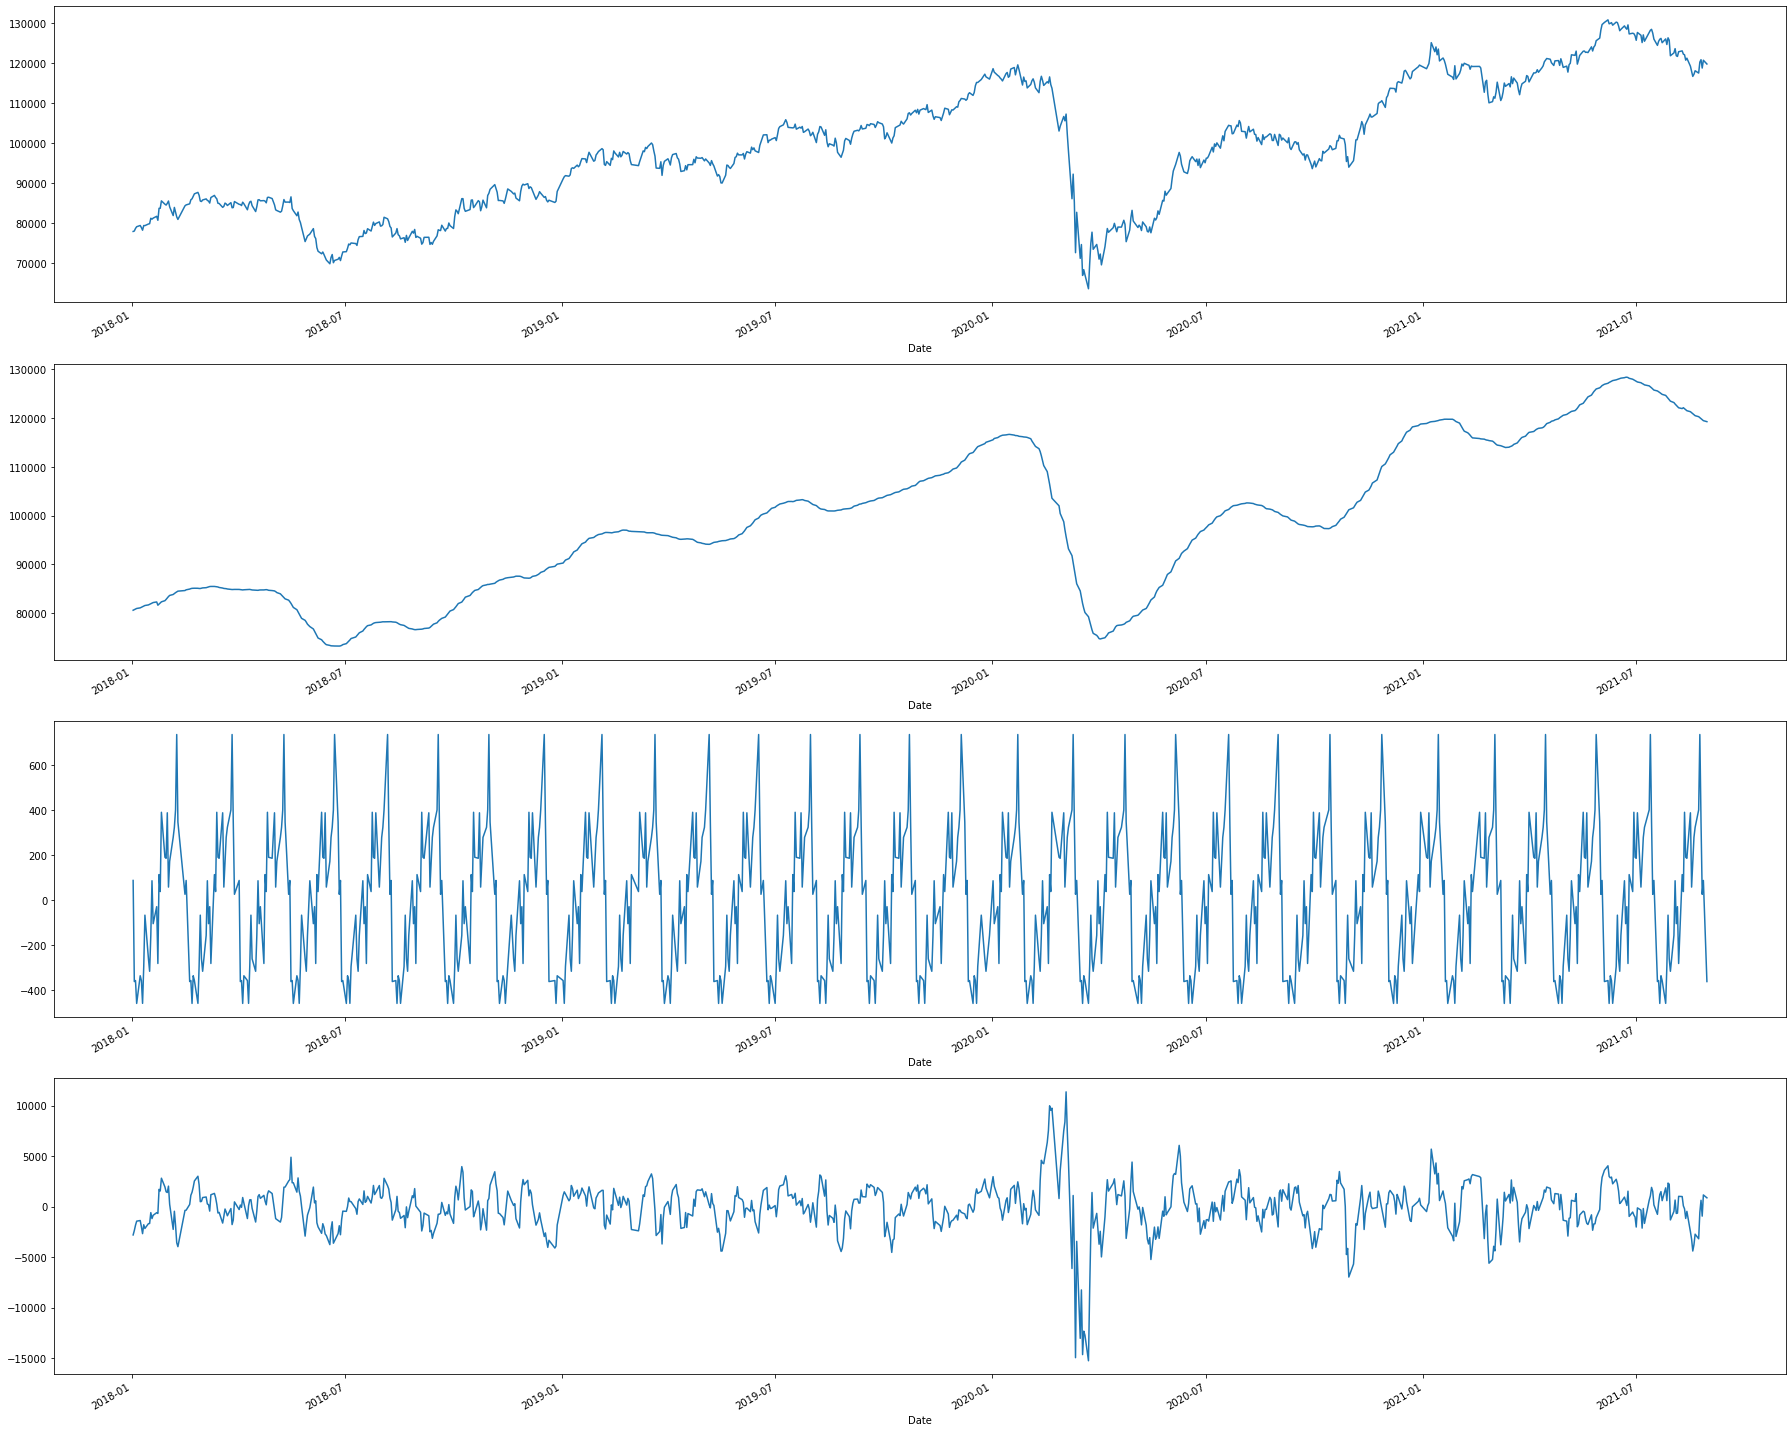

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(25,20))
decomposicao.observed.plot(ax=ax1)
decomposicao.trend.plot(ax=ax2)
decomposicao.seasonal.plot(ax=ax3)
decomposicao.resid.plot(ax=ax4)
plt.tight_layout()

Gráfico de tendência detalhado.

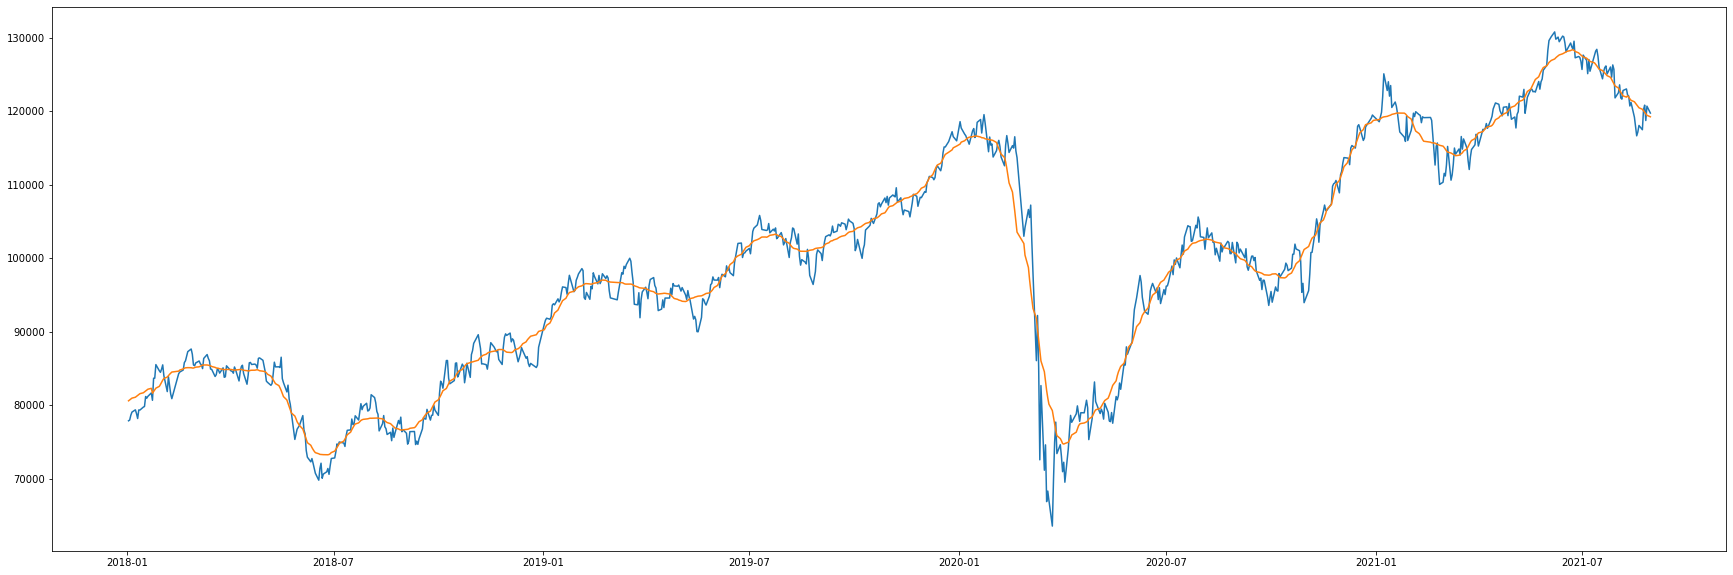

In [11]:
ax, fig = plt.subplots(figsize=(30,10))
plt.plot(decomposicao.observed)
plt.plot(decomposicao.trend)

# Calculo da média móvel

Explicação da forma de cálculo da média móvel.

In [12]:
df['Close'].rolling(7).mean()

Date
2018-01-02              NaN
2018-01-03              NaN
2018-01-04              NaN
2018-01-05              NaN
2018-01-08              NaN
                  ...      
2021-08-24    118089.714286
2021-08-25    118323.714286
2021-08-26    118440.857143
2021-08-27    119017.285714
2021-08-30    119385.142857
Name: Close, Length: 902, dtype: float64

Aplicação da média móvel por 7, 14 e 21 dias.

In [13]:
media_movel7d = df['Close'].rolling(7).mean()
media_movel14d = df['Close'].rolling(14).mean()
media_movel21d = df['Close'].rolling(21).mean()

Gráfico de demonstração da média móvel por 7, 14 e 21 dias.

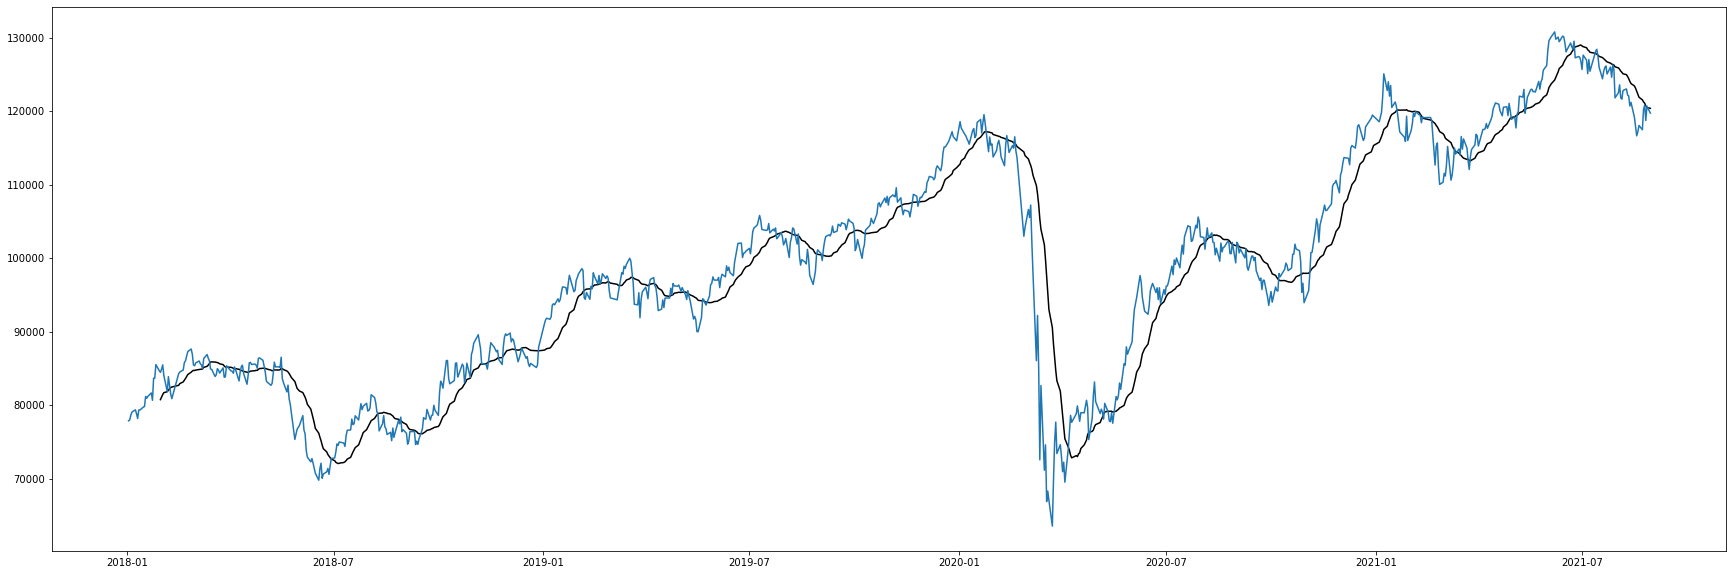

In [14]:
ax, fig = plt.subplots(figsize=(30,10))
#plt.plot(media_movel7d, 'orange')
#plt.plot(media_movel14d, 'red')
plt.plot(media_movel21d, 'black')
plt.plot(df['Close'])

# Treinamento dos dados para a predição

Nesta parte são separados os dados de treinamento e de teste para análise de quanto o modelo está performando.

Importação das bibliotecas para o treinamento do modelo.

In [15]:
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM

Para este modelo, será utilizado somente os valor de fechamento da ação **Close** para a predição.

In [16]:
# Criação de um novo DaraFrame somente com a colula 'Close'
data = df.filter(['Close'])
num_max = data.max()[0]
# Converter o DataFrame em um numpy array
dataset = data.values

# Pega a quantidade de linhas para o treino
training_data_len = math.ceil( len(dataset) * 0.8)
training_data_len

722

Realizada a normalização dos dados

In [17]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(dataset)

#scaled_data

Separação do conjunto de treino e de teste.

In [18]:
# Criação do conjunto de dados de treino
# Criação do conjunto de dados de treino normalizado
train_data = scaled_data[0:training_data_len , :]

# Separação entre os conjuntos de dados x_tran e y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

Transformando os dados em array **NUMPY**

In [19]:
x_train, y_train = np.array(x_train), np.array(y_train)

Realizando a preparação dos índices para o modelo.

In [20]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(662, 60, 1)

#### Arquitetura da LSTM
[A LSTM é uma arquitetura de rede neural recorrente (RNN) que “lembra” valores em intervalos arbitrários. A LSTM é bem adequada para classificar, processar e prever séries temporais com intervalos de tempo de duração desconhecida. A insensibilidade relativa ao comprimento do gap dá uma vantagem à LSTM em relação a RNNs tradicionais (também chamadas “vanilla”), Modelos Ocultos de Markov (MOM) e outros métodos de aprendizado de sequências.](https://www.deeplearningbook.com.br/arquitetura-de-redes-neurais-long-short-term-memory/)

Criação do modelo LSTM.

In [21]:
# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

Compilação do modelo.

In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')

Treinamento do modelo.

In [23]:
model.fit(x_train, y_train, batch_size=1, epochs=15)

Epoch 1/15
662/662 [==============================] - 8s 12ms/step - loss: 0.0137
Epoch 2/15
662/662 [==============================] - 8s 12ms/step - loss: 0.0060
Epoch 3/15
662/662 [==============================] - 8s 12ms/step - loss: 0.0050
Epoch 4/15
662/662 [==============================] - 8s 11ms/step - loss: 0.0046
Epoch 5/15
662/662 [==============================] - 8s 12ms/step - loss: 0.0038
Epoch 6/15
662/662 [==============================] - 9s 13ms/step - loss: 0.0039
Epoch 7/15
662/662 [==============================] - 9s 14ms/step - loss: 0.0036
Epoch 8/15
662/662 [==============================] - 10s 16ms/step - loss: 0.0036
Epoch 9/15
662/662 [==============================] - 10s 15ms/step - loss: 0.0035
Epoch 10/15
662/662 [==============================] - 9s 14ms/step - loss: 0.0037
Epoch 11/15
662/662 [==============================] - 9s 14ms/step - loss: 0.0035
Epoch 12/15
662/662 [==============================] - 9s 14ms/step - loss: 0.0034
Epoch 13/15

# Verificação do modelo

Separação dos dados de teste para a verificação no novo modelo treinado.

In [24]:
test_data = scaled_data[training_data_len-60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

Transformando os dados do **x_teste** em array **NUMPY**.

In [25]:
x_test = np.array(x_test)

Realizando a preparação dos índices para o modelo.

In [26]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(180, 60, 1)

Realizando as predições nos dados de teste.

In [27]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

Verificando o **rmse**, que quer dizer: o erro quadrático médio ( RMSE ) é uma medida frequentemente usada das diferenças entre os valores (valores de amostra ou população) previstos por um modelo ou um estimador e os valores observados, que foi utilizado para a medição dos erros.

In [28]:
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

120.09635416666667

Visualização dos dados de treino e de teste em forma de gráfico.

<ipython-input-29-c5817d9f9aba>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



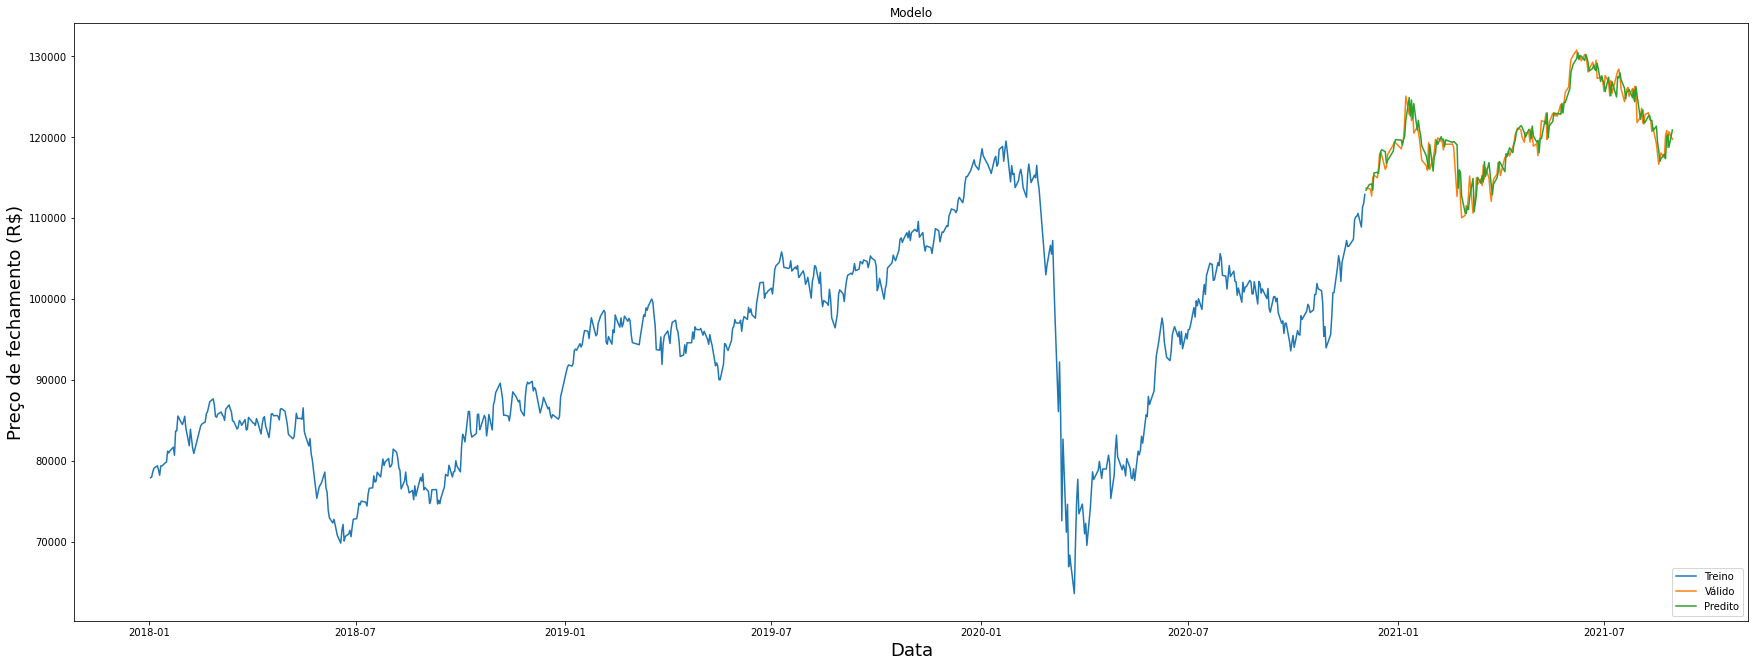

In [29]:
# Plot dos dados
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualização dos dados
plt.figure(figsize=(30,11))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel('Preço de fechamento (R$)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
#plt.plot(valid[['Close', 'Predictions', 'Predict']])
plt.legend(['Treino', 'Válido', 'Predito'], loc='lower right')
plt.show()

# Predição da ação!

Após a verificação do desempenho do modelo, podemos realizar predições para dias futuros, lembrando que para cada dia a mais predito o erro aumenta.

Coleta dos valores de fechamento da ação.

In [30]:
new_df = df.filter(['Close'])

Utilização dos últimos 60 dias para a predição dos dias futuros

In [31]:
last_60_days = new_df[-60:].values

Função de predição para os dias futuros.

In [32]:
days_pred_price = []
for i in range(10):
    #print(i)
    if i == 0:
        last_60_days_scaled = scaler.transform(last_60_days)
        X_test = []
        X_test.append(last_60_days_scaled)
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        pred_price = model.predict(X_test)
        last_60_days_scaled = np.append(last_60_days_scaled, pred_price[0])
        #print(last_60_days_scaled)
        #last_60_days_scaled.append(pred_price)
        pred_price = scaler.inverse_transform(pred_price)
        days_pred_price.append(pred_price)
    else:
        last_60_days_scaled = last_60_days_scaled[-60:]
        X_test = []
        X_test.append(last_60_days_scaled)
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        pred_price = model.predict(X_test)
        last_60_days_scaled = np.append(last_60_days_scaled, pred_price[0])
        #print(last_60_days_scaled)
        #last_60_days_scaled.append(pred_price)
        pred_price = scaler.inverse_transform(pred_price)
        days_pred_price.append(pred_price)

Função para extrair os valores gerados para cada dia.

In [33]:
days_pred_price_real = []
for i in days_pred_price:
    for j in i:
        for k in j:
            days_pred_price_real.append(k)

Visualização dos valores preditos.

In [34]:
days_pred_price_real

[119684.516,
 120059.63,
 120279.195,
 120496.93,
 120714.555,
 120927.19,
 121136.164,
 121341.78,
 121543.97,
 121742.32]

Geração do conjunto de dados que será acoplado ao conjunto principal

In [35]:
ix_y_pred = []
for i in range(len(days_pred_price_real)):
    ix_y_pred.append(max(df.index) + pd.DateOffset(i+1))
    
df_y_pred = pd.DataFrame(data=days_pred_price_real, index=ix_y_pred, columns=['Predict'])

Serie do conjunto de dados predito.

In [36]:
df_y_pred

Predict
2021-08-31  119684.515625
2021-09-01  120059.632812
2021-09-02  120279.195312
2021-09-03  120496.929688
2021-09-04  120714.554688
2021-09-05  120927.187500
2021-09-06  121136.164062
2021-09-07  121341.781250
2021-09-08  121543.968750
2021-09-09  121742.320312

Inclusão dos valores reais com os valores preditos pelo modelo.

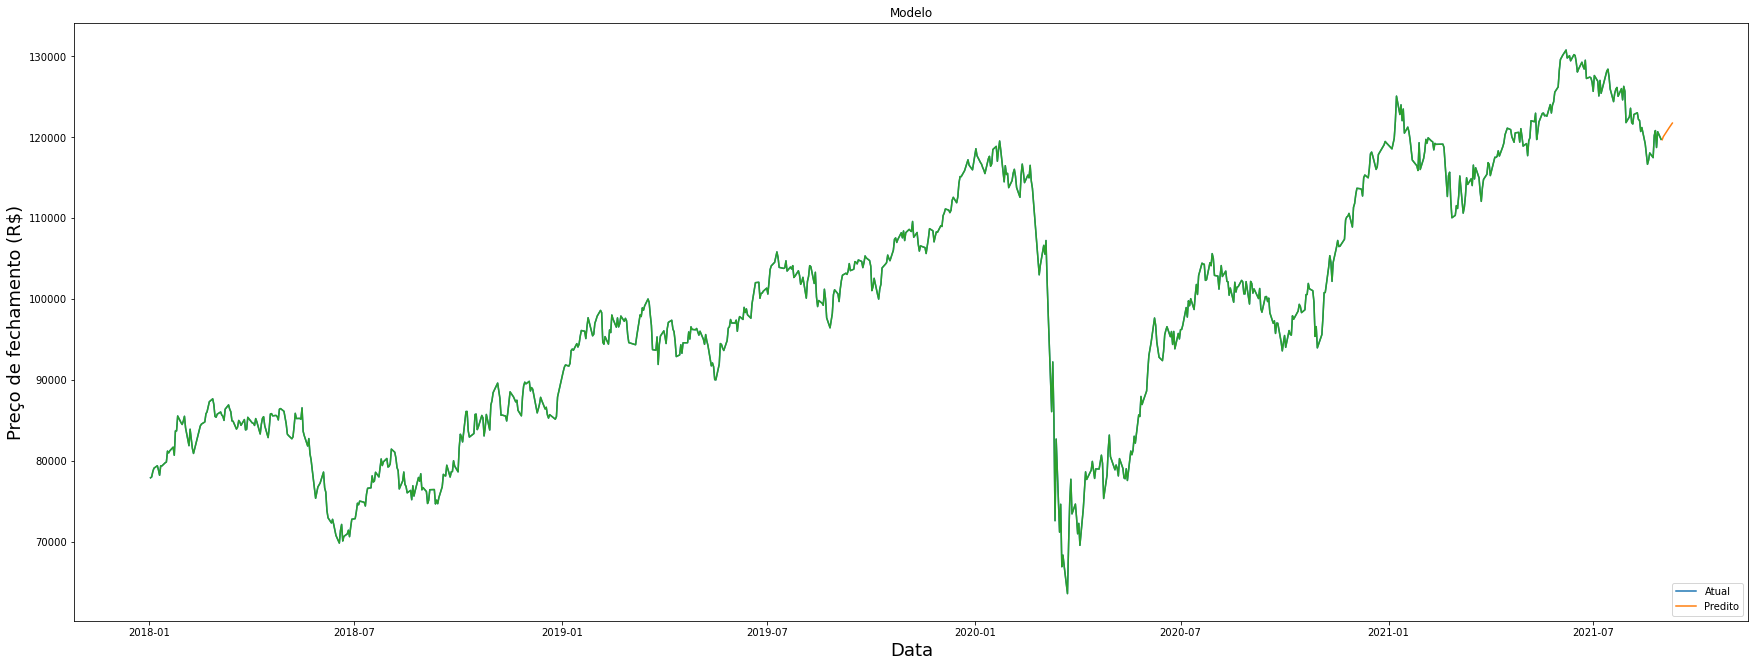

In [37]:
df = df.append(df_y_pred, sort=False)

plt.figure(figsize=(30,11))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel('Preço de fechamento (R$)', fontsize = 18)
plt.plot(df[['Close', 'Predict']])
plt.plot(df['Close'])
plt.legend(['Atual', 'Predito'], loc='lower right')
plt.show()